In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
from kdg.utils import plot_2dsim, gaussian_sparse_parity, generate_gaussian_parity
import tensorflow_addons as tfa
from tqdm import tqdm

## Define encoder and task heads

In [66]:
# network architecture [1000, 1000, 1000, 1000, 2]
def get_encoder(input_size, latent_dim, compile_kwargs):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=latent_dim, kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [67]:
def task_head(latent_dim, num_classes, compile_kwargs_head):
    head = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    head.add(keras.layers.Dense(100, kernel_initializer=initializer, input_shape=(latent_dim,)))
    head.add(keras.layers.Activation(activations.relu))
    head.add(keras.layers.Dense(100, kernel_initializer=initializer))
    head.add(keras.layers.Activation(activations.relu))
    head.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    head.compile(**compile_kwargs_head)
    return head

## Parameters

In [141]:
encoder_iterations = 500
head_iteration = 50
sample_per_task = 100
noise_dim = 10
latent_dim = 2
task_angles = np.linspace(0,np.pi/4,5)
classes_per_task = 2
heads = {}
X_data = {}
y_data = {}

In [142]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [143]:
compile_kwargs = {
        "loss": SupervisedContrastiveLoss(),
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=True)
fit_kwargs = {
        "epochs": encoder_iterations,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [144]:
compile_kwargs_head = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-3),
    }
callback_head = keras.callbacks.EarlyStopping(monitor="loss", patience=100, verbose=True)
fit_kwargs_head = {
        "epochs": head_iteration,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback_head],
    }

In [146]:
total_task_seen = 0
encoder = get_encoder(input_size=noise_dim+latent_dim, latent_dim=latent_dim, compile_kwargs=compile_kwargs)

for ii, angle in enumerate(task_angles):
    print('Doing Task ', ii+1)
    
    X, y = generate_gaussian_parity(sample_per_task, angle_params=angle)
    X_noise = np.random.uniform(
                low=-1, high=1, size=(sample_per_task, noise_dim)
            )
    X = np.concatenate((X, X_noise), axis=1)
    X_data[ii] = X
    y_data[ii] = y

    converted_y = y.copy()
    for jj in range(1,total_task_seen):
        embedding = encoder.predict(X)
        head_predicted_label = np.argmax(
                heads[jj].predict(embedding),
                axis=1
            )
        converted_y += 2**jj * head_predicted_label

    encoder.fit(X, converted_y, **fit_kwargs)
    heads[ii] = task_head(latent_dim=latent_dim, num_classes=classes_per_task, compile_kwargs_head=compile_kwargs_head)

    embedding = encoder.predict(X)
    heads[ii].fit(
            embedding, 
            keras.utils.to_categorical(y), 
            **fit_kwargs_head
        )

    total_task_seen += 1
        

Doing Task  1


2024-06-15 21:54:06.064498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x36x1x1xi1>'


Epoch 252: early stopping
1/4 [======>.......................] - ETA: 0s

2024-06-15 21:54:22.188435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 49ms/step


2024-06-15 21:54:22.618636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Doing Task  2
4/4 [==============================] - 0s 2ms/step


2024-06-15 21:54:54.081295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Doing Task  3
1/4 [======>.......................] - ETA: 0s

2024-06-15 21:54:57.809797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 53ms/step
Epoch 316: early stopping
4/4 [==============================] - 0s 7ms/step


2024-06-15 21:55:17.417606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Doing Task  4
1/4 [======>.......................] - ETA: 0s

2024-06-15 21:55:21.243207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 41ms/step
Epoch 246: early stopping
4/4 [==============================] - 0s 2ms/step


2024-06-15 21:55:35.407646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Doing Task  5
4/4 [==============================] - 0s 32ms/step


2024-06-15 21:55:39.671091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 301: early stopping
4/4 [==============================] - 0s 2ms/step


2024-06-15 21:55:57.020761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

313/313 [==============================] - 1s 2ms/step


<AxesSubplot: >

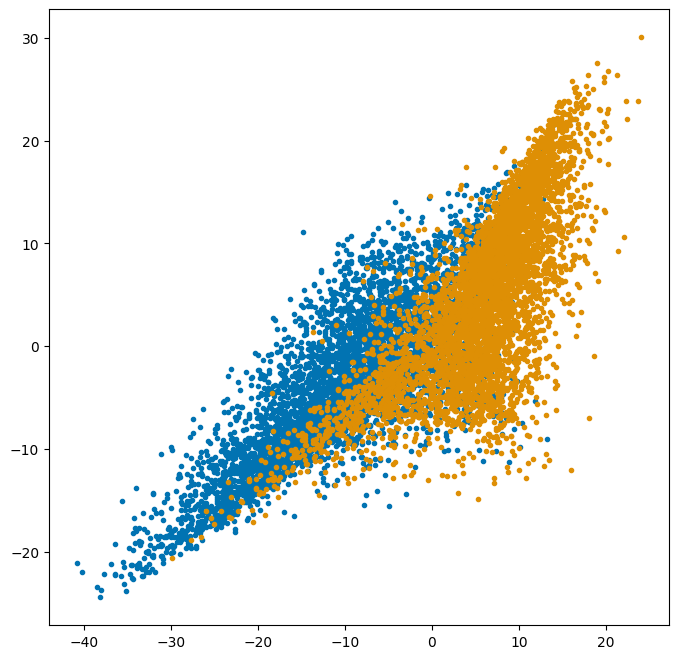

In [149]:
X, y = generate_gaussian_parity(10000, angle_params=task_angles[1])
X_noise = np.random.uniform(
            low=-1, high=1, size=(10000, noise_dim)
        )
X = np.concatenate((X, X_noise), axis=1)
embedding = encoder.predict(X)
plot_2dsim(embedding, y)

In [150]:
np.mean(np.argmax(heads[1].predict(embedding),axis=1)==y)

313/313 [==============================] - 1s 2ms/step


0.7984

In [128]:
converted_y

array([ 0, 14,  0,  0, 14,  2, 14,  0,  0,  0,  0,  0,  2,  0,  0,  0, 12,
       10,  0,  0, 15, 13, 15, 15, 15,  5,  1,  5, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 11, 15, 15, 13, 15, 15, 15, 15, 15, 15, 15,
        1, 15, 11, 13,  3, 15, 15, 15, 15,  3, 15, 15, 11,  1,  1,  1,  3,
       15,  0,  0,  0, 14,  0,  0,  0, 10, 14,  0,  0,  0,  0,  0,  0,  0,
        0,  4, 10,  2,  0,  0,  0,  0,  0, 14,  0,  2,  0, 14,  0])